In [4]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

In [19]:
# Cargar modelo y tokenizador
model_name = "ICB-UMA/ClinLinker-KB-P"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Detectar si hay una GPU disponible y asignar el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Crear el pipeline de NER usando la GPU si está disponible
nlp_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0 if torch.cuda.is_available() else -1)


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ICB-UMA/ClinLinker-KB-P and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
text = "El paciente presenta síntomas de diabetes mellitus tipo 2."

# Obtener las entidades médicas detectadas
entities = nlp_pipeline(text)

# Mostrar resultados
for entity in entities:
    print(f"Texto: {entity['word']}, Etiqueta: {entity['entity_group']}, Puntaje: {entity['score']:.2f}")


Texto:  El, Etiqueta: LABEL_1, Puntaje: 0.53
Texto:  paciente presenta, Etiqueta: LABEL_0, Puntaje: 0.53
Texto:  síntomas, Etiqueta: LABEL_1, Puntaje: 0.52
Texto:  de diabetes, Etiqueta: LABEL_0, Puntaje: 0.51
Texto:  mellitus tipo 2 y, Etiqueta: LABEL_1, Puntaje: 0.53
Texto:  nefropatía diabética, Etiqueta: LABEL_0, Puntaje: 0.51
Texto: ., Etiqueta: LABEL_1, Puntaje: 0.55


In [21]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
tokenizer = AutoTokenizer.from_pretrained("BSC-TeMU/roberta-base-biomedical-es")
model = AutoModelForMaskedLM.from_pretrained("BSC-TeMU/roberta-base-biomedical-es")
from transformers import pipeline
unmasker = pipeline('fill-mask', model="BSC-TeMU/roberta-base-biomedical-es")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [22]:
unmasker("El único antecedente personal a reseñar era la <mask> arterial.")

[{'score': 0.9855039715766907,
  'token': 3529,
  'token_str': ' hipertensión',
  'sequence': ' El único antecedente personal a reseñar era la hipertensión arterial.'},
 {'score': 0.003914060536772013,
  'token': 1945,
  'token_str': ' diabetes',
  'sequence': ' El único antecedente personal a reseñar era la diabetes arterial.'},
 {'score': 0.0024846442975103855,
  'token': 11483,
  'token_str': ' hipotensión',
  'sequence': ' El único antecedente personal a reseñar era la hipotensión arterial.'},
 {'score': 0.0023484532721340656,
  'token': 12238,
  'token_str': ' Hipertensión',
  'sequence': ' El único antecedente personal a reseñar era la Hipertensión arterial.'},
 {'score': 0.0008009266457520425,
  'token': 2267,
  'token_str': ' presión',
  'sequence': ' El único antecedente personal a reseñar era la presión arterial.'}]

In [23]:
unmasker("El paciente presenta síntomas de <mask> mellitus tipo 2.")

[{'score': 0.9982359409332275,
  'token': 1945,
  'token_str': ' diabetes',
  'sequence': ' El paciente presenta síntomas de diabetes mellitus tipo 2.'},
 {'score': 0.0014360434142872691,
  'token': 6423,
  'token_str': ' Diabetes',
  'sequence': ' El paciente presenta síntomas de Diabetes mellitus tipo 2.'},
 {'score': 6.710708839818835e-05,
  'token': 6770,
  'token_str': ' DM',
  'sequence': ' El paciente presenta síntomas de DM mellitus tipo 2.'},
 {'score': 4.553172766463831e-05,
  'token': 30586,
  'token_str': 'diabetes',
  'sequence': ' El paciente presenta síntomas dediabetes mellitus tipo 2.'},
 {'score': 2.2063168216845952e-05,
  'token': 796,
  'token_str': ' enfermedad',
  'sequence': ' El paciente presenta síntomas de enfermedad mellitus tipo 2.'}]

In [27]:
def merge_consecutive_entities(entities, text):
    entities = sorted(entities, key=lambda x: x['start'])
    merged_entities = []
    current_entity = None

    for entity in entities:
        if current_entity is None:
            current_entity = entity
        elif (
            entity['entity_group'] == current_entity['entity_group'] and
            (entity['start'] <= current_entity['end'])
        ):
            # Merge based on start and end positions in the text
            current_entity['end'] = max(current_entity['end'], entity['end'])
            current_entity['word'] = text[current_entity['start']:current_entity['end']]
            current_entity['score'] = (current_entity['score'] + entity['score']) / 2  
        else:
            merged_entities.append(current_entity)
            current_entity = entity
    if current_entity:
        merged_entities.append(current_entity)

    return merged_entities


In [24]:
from transformers import pipeline

# Load the model
model_path = "Helios9/BIOMed_NER"
pipe = pipeline(
    task="token-classification",
    model=model_path,
    tokenizer=model_path,
    aggregation_strategy="simple"
)



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
text = ("patients diagnosed in the inner lower quadrant of breast that went under lumpeoctomy")
result = pipe(text)
final_result=merge_consecutive_entities(result,text)
print(final_result)

[{'entity_group': 'Biological_structure', 'score': 0.9201284646987915, 'word': ' inner lower quadrant of breast', 'start': 25, 'end': 56}, {'entity_group': 'Therapeutic_procedure', 'score': 0.514445, 'word': 'lumpeoctomy', 'start': 72, 'end': 84}]


In [6]:
from urllib.request import urlopen, Request
from urllib.parse import quote
import json

baseUrl = 'https://snowstorm-training.snomedtools.org/snowstorm/snomed-ct'
edition = 'MAIN'

# IMPORTANT! You must update this user agent to avoid having your IP banned for 24 hours.
# Replace with a contact email so that we can contact you if your script causes excessive load on the public server
# For example: user_agent = 'example@example.com'
user_agent = 'unaiigartua2@gmail.com'

In [48]:
def urlopen_with_header(url):
    # adds User-Agent header otherwise urlopen on its own gets an IP blocked response
    req = Request(url)
    req.add_header('User-Agent', user_agent)
    return urlopen(req)


    
 #Prints snomed code for searched disease or symptom
def getSnomedCodeSimilar(searchTerm):
    #url = baseUrl + '/browser/' + edition + '/descriptions?term=' + quote(searchTerm) + '&conceptActive=true&groupByConcept=false&searchMode=STANDARD&offset=0&limit=50'
    url = 'https://snowstorm-training.snomedtools.org/snowstorm/snomed-ct/browser/MAIN/descriptions?term=' + quote(searchTerm) + '&active=true&conceptActive=true&groupByConcept=false&searchMode=STANDARD&offset=0&limit=50'
    print(url)
    response = urlopen_with_header(url).read()
    data = json.loads(response.decode('utf-8'))

    # for term in data['items']:
    #   print(term)  
    #   if searchTerm in term['term']:
    #     print("{} : {}".format(term['term'], term['concept']['conceptId']))


    diccionario = []
    for term in data['items']:
        print(term)
        diccionario.append([term['term'], term['concept']['conceptId']])
    
    return diccionario

    

 

In [50]:
terms = getSnomedCodeSimilar('lumpectomy')

https://snowstorm-training.snomedtools.org/snowstorm/snomed-ct/browser/MAIN/descriptions?term=lumpectomy&active=true&conceptActive=true&groupByConcept=false&searchMode=STANDARD&offset=0&limit=50
{'term': 'Lumpectomy', 'active': True, 'languageCode': 'en', 'module': '900000000000207008', 'concept': {'conceptId': '392022002', 'active': True, 'definitionStatus': 'FULLY_DEFINED', 'moduleId': '900000000000207008', 'fsn': {'term': 'Excision of mass (procedure)', 'lang': 'en'}, 'pt': {'term': 'Excision of mass', 'lang': 'en'}, 'id': '392022002'}}
{'term': 'Breast lumpectomy', 'active': True, 'languageCode': 'en', 'module': '900000000000207008', 'concept': {'conceptId': '392021009', 'active': True, 'definitionStatus': 'FULLY_DEFINED', 'moduleId': '900000000000207008', 'fsn': {'term': 'Lumpectomy of breast (procedure)', 'lang': 'en'}, 'pt': {'term': 'Lumpectomy of breast', 'lang': 'en'}, 'id': '392021009'}}
{'term': 'Lumpectomy of breast', 'active': True, 'languageCode': 'en', 'module': '900000

In [38]:
print(terms)

[['Lumpectomy', '392022002'], ['Breast lumpectomy', '392021009'], ['Lumpectomy of breast', '392021009'], ['Lumpectomy breast sample', '309546004'], ['Lumpectomy of left breast', '735085002'], ['Lumpectomy of right breast', '735086001'], ['Lumpectomy of breast (procedure)', '392021009'], ['Lumpectomy breast sample (specimen)', '309546004'], ['Lumpectomy of left breast (procedure)', '735085002'], ['Lumpectomy of right breast (procedure)', '735086001'], ['A treatment approach that utilizes a localized form of radiation that treats only the lumpectomy bed plus a 1-2 cm margin.', '22741000087109'], ['A treatment approach that utilises a localised form of radiation that treats only the lumpectomy bed plus a 1-2 cm margin.', '22741000087109']]


In [39]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity


model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


def get_mean_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    attention_mask = inputs["attention_mask"]
    mask_expanded = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask_expanded
    summed = torch.sum(masked_embeddings, dim=1)
    counts = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    mean_pooled = summed / counts
    return mean_pooled



In [ ]:
# Ejemplo de textos
text1 = "inner lower quadrant of breast"
text2 = "Entire lower inner quadrant of breast"

emb1 = get_mean_embedding(text1)
emb2 = get_mean_embedding(text2)

similarity = cosine_similarity(emb1.numpy(), emb2.numpy())
print(f"Cosine Similarity: {similarity[0][0]}")


Cosine Similarity: 0.9529097080230713


In [41]:
emb1 = get_mean_embedding("lumpectomy")

for term in terms:
    emb2 = get_mean_embedding(term[0])
    similarity = cosine_similarity(emb1.numpy(), emb2.numpy())
    # añadir la similaridad al diccionario
    term.append(similarity[0][0])

print(terms)
    

[['Lumpectomy', '392022002', 0.9178743], ['Breast lumpectomy', '392021009', 0.91275537], ['Lumpectomy of breast', '392021009', 0.90502787], ['Lumpectomy breast sample', '309546004', 0.88890713], ['Lumpectomy of left breast', '735085002', 0.8876601], ['Lumpectomy of right breast', '735086001', 0.8845887], ['Lumpectomy of breast (procedure)', '392021009', 0.8816737], ['Lumpectomy breast sample (specimen)', '309546004', 0.8757781], ['Lumpectomy of left breast (procedure)', '735085002', 0.88002205], ['Lumpectomy of right breast (procedure)', '735086001', 0.8807367], ['A treatment approach that utilizes a localized form of radiation that treats only the lumpectomy bed plus a 1-2 cm margin.', '22741000087109', 0.8336814], ['A treatment approach that utilises a localised form of radiation that treats only the lumpectomy bed plus a 1-2 cm margin.', '22741000087109', 0.81605613]]


In [42]:
order_terms = sorted(terms, key=lambda x: x[2], reverse=True)
print(order_terms)


[['Lumpectomy', '392022002', 0.9178743], ['Breast lumpectomy', '392021009', 0.91275537], ['Lumpectomy of breast', '392021009', 0.90502787], ['Lumpectomy breast sample', '309546004', 0.88890713], ['Lumpectomy of left breast', '735085002', 0.8876601], ['Lumpectomy of right breast', '735086001', 0.8845887], ['Lumpectomy of breast (procedure)', '392021009', 0.8816737], ['Lumpectomy of right breast (procedure)', '735086001', 0.8807367], ['Lumpectomy of left breast (procedure)', '735085002', 0.88002205], ['Lumpectomy breast sample (specimen)', '309546004', 0.8757781], ['A treatment approach that utilizes a localized form of radiation that treats only the lumpectomy bed plus a 1-2 cm margin.', '22741000087109', 0.8336814], ['A treatment approach that utilises a localised form of radiation that treats only the lumpectomy bed plus a 1-2 cm margin.', '22741000087109', 0.81605613]]


In [43]:
import matplotlib.pyplot as plt

/var/folders/ws/jlf7zj8x60lfl1vprb7gt6lr0000gn/T/ipykernel_1503/3786119875.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


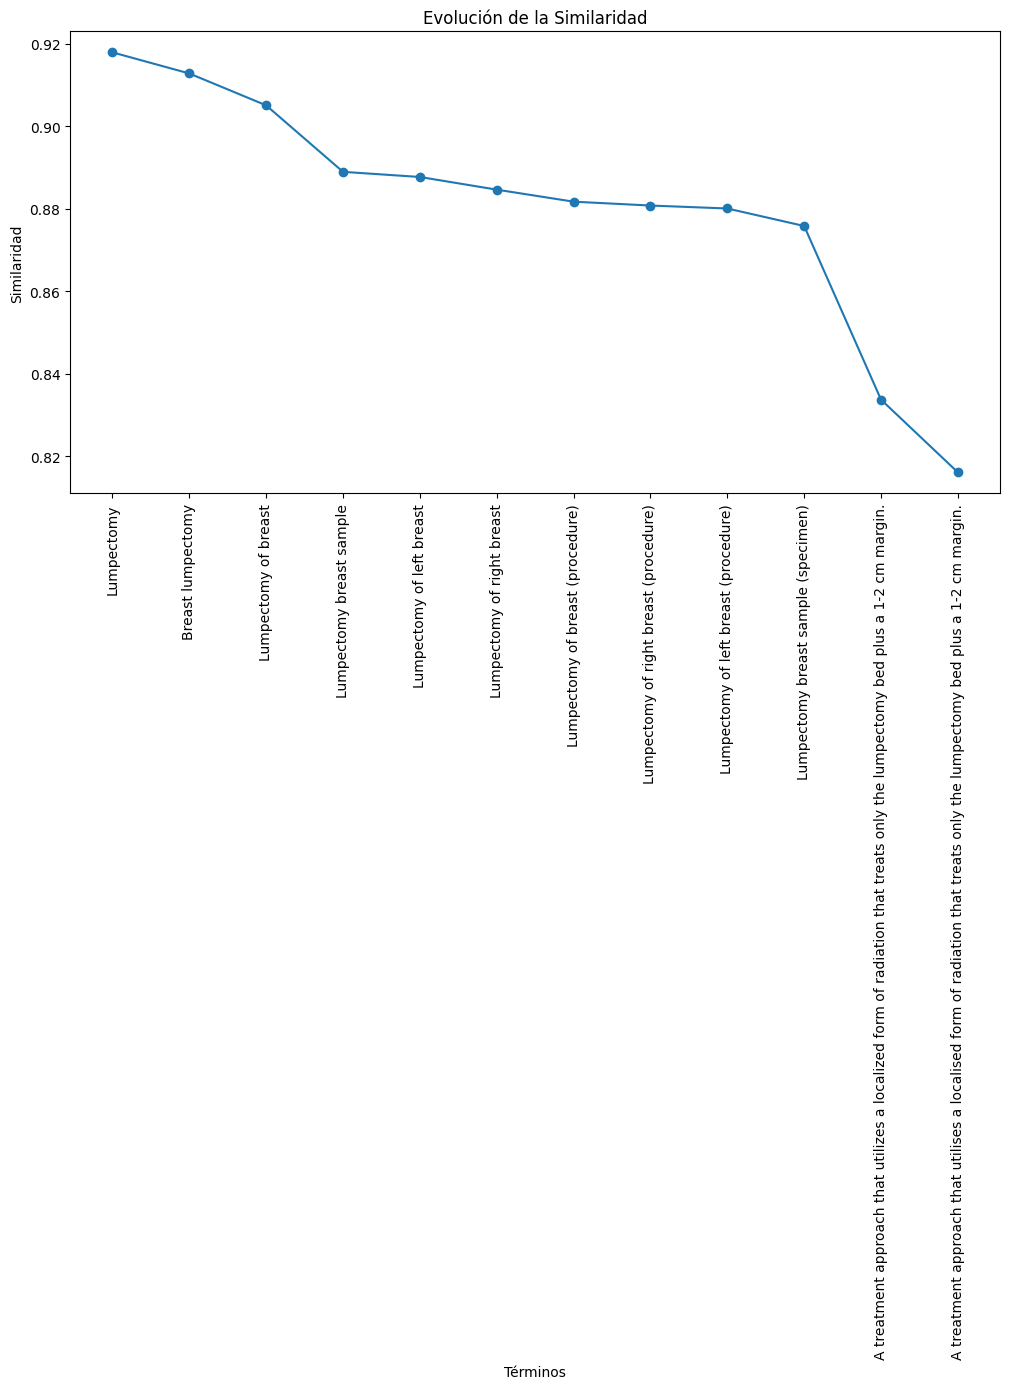

In [44]:
nombres = [item[0] for item in order_terms]
valores = [item[2] for item in order_terms]

plt.figure(figsize=(12, 6))
plt.plot(valores, marker='o', linestyle='-')
plt.xticks(range(len(nombres)), nombres, rotation=90)
plt.xlabel("Términos")
plt.ylabel("Similaridad")
plt.title("Evolución de la Similaridad")
plt.tight_layout()
plt.show()

In [1]:
import requests

In [9]:
import requests

def snomed_to_omop_concept(snomed_code: str):
    """
    Dado un código SNOMED, devuelve su concepto equivalente en OMOP.
    """
    url = "https://api.ohdsi.org/WebAPI/vocabulary/search"
    headers = {"Content-Type": "application/json"}
    payload = {
        "QUERY": snomed_code,
        "VOCABULARY_ID": ["SNOMED"]
    }

    response = requests.post(url, json=payload, headers=headers)
    if response.status_code != 200:
        raise Exception(f"Error en la request: {response.status_code} - {response.text}")

    results = response.json()
    if not results:
        print("❌ No se encontró ningún resultado.")
        return None

    first = results[0]
    return {
        "concept_id": first["CONCEPT_ID"],
        "concept_name": first["CONCEPT_NAME"],
        "domain_id": first["DOMAIN_ID"],
        "vocabulary_id": first["VOCABULARY_ID"],
        "standard_concept": first["STANDARD_CONCEPT"],
        "concept_class_id": first["CONCEPT_CLASS_ID"]
    }

# 🔎 Prueba con un SNOMED code
snomed_code = "19100000"
concept_info = snomed_to_omop_concept(snomed_code)
concept_info


{'concept_id': 3524377,
 'concept_name': '10g monofilament sensation plantar aspect of little toe right foot absent',
 'domain_id': 'Observation',
 'vocabulary_id': 'SNOMED',
 'standard_concept': 'N',
 'concept_class_id': 'Undefined'}

In [8]:
snomed_code = "19100000"
snomed_to_athena_omop(snomed_code)

SNOMED: 19100000
ATHENA conceptId: 3524377
Concept name: 10g monofilament sensation plantar aspect of little toe right foot absent
Domain: Observation


{'CONCEPT_ID': 3524377,
 'CONCEPT_NAME': '10g monofilament sensation plantar aspect of little toe right foot absent',
 'STANDARD_CONCEPT': 'N',
 'STANDARD_CONCEPT_CAPTION': 'Non-Standard',
 'INVALID_REASON': 'U',
 'INVALID_REASON_CAPTION': 'Invalid',
 'CONCEPT_CODE': '216191000000104',
 'DOMAIN_ID': 'Observation',
 'VOCABULARY_ID': 'SNOMED',
 'CONCEPT_CLASS_ID': 'Undefined',
 'VALID_START_DATE': 1143849600000,
 'VALID_END_DATE': 1143849600000}

In [10]:
import pandas as pd
import sqlite3

# Cargar solo las columnas necesarias
df = pd.read_csv("CONCEPT.csv", sep='\t', usecols=[
    "concept_id", "concept_name", "domain_id", "vocabulary_id",
    "concept_class_id", "standard_concept", "concept_code"
])

# Crear conexión SQLite y guardar
conn = sqlite3.connect("omop_snomed.db")
df.to_sql("concepts", conn, if_exists="replace", index=False)

# Crear índices para búsquedas rápidas
conn.execute("CREATE INDEX IF NOT EXISTS idx_code ON concepts(concept_code);")
conn.execute("CREATE INDEX IF NOT EXISTS idx_name ON concepts(concept_name);")
conn.commit()


/var/folders/ws/jlf7zj8x60lfl1vprb7gt6lr0000gn/T/ipykernel_68009/2683261114.py:5: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CONCEPT.csv", sep='\t', usecols=[


In [11]:
def find_concept_by_code(code: str, conn):
    query = """
    SELECT concept_id, concept_name, domain_id, vocabulary_id, standard_concept
    FROM concepts
    WHERE concept_code = ?
    """
    return pd.read_sql_query(query, conn, params=(code,))

In [14]:
# Conexión a la base
conn = sqlite3.connect("omop_snomed.db")

# Buscar por código SNOMED
find_concept_by_code("392021009", conn)

,concept_id,concept_name,domain_id,vocabulary_id,standard_concept
0,4213045,Lumpectomy of breast,Procedure,SNOMED,S


In [16]:
import pandas as pd

syn_df = pd.read_csv("CONCEPT_SYNONYM.csv", sep="\t", usecols=["concept_id", "concept_synonym_name"])
syn_df.drop_duplicates(inplace=True)  # Por si acaso


In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

# Embeddings de los sinónimos
texts = syn_df["concept_synonym_name"].tolist()
embeddings = model.encode(texts, show_progress_bar=True)


/Users/unaiigartua/anaconda3/envs/TFG_CDIA/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
Batches:   0%|          | 12/57951 [02:13<179:28:53, 11.15s/it]


KeyboardInterrupt: 

In [ ]:
import faiss
import numpy as np

# Convertir a float32 para FAISS
embeddings = np.array(embeddings).astype("float32")

# Crear el índice (flat L2 por simplicidad)
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# Guardar referencia de qué índice corresponde a qué concepto
concept_ids = syn_df["concept_id"].tolist()

In [ ]:
def search_description(text_query, k=5):
    vec = model.encode([text_query]).astype("float32")
    distances, indices = index.search(vec, k)
    results = []

    for idx in indices[0]:
        cid = concept_ids[idx]
        synonym = syn_df.iloc[idx]["concept_synonym_name"]
        results.append((cid, synonym))

    return results


In [ ]:
search_description("lower inner quadrant of breast")


In [18]:
!pip freeze > requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
pip 